#### <center>Intermediate Python and Software Enginnering</center>


## <center>Section 07 - Algorithms - Exercise Solutions</center>


### <center>Innovation Scholars Programme</center>
### <center>King's College London, Medical Research Council and UKRI <center>

# Algorithms Exercises

The purpose of this notebook is to explore some algorithm implementation.

### Dose Calculation

A clinician wants to deliver a dose to a patient with a machine that has 4 settings.
Note that this is not how radiotherapy works!
The clinician wants to use the fewest number of shots to deliver the necessary therapy.
A greedy approach only delivers the minimum shot count with certain shot values (1, 2, 5, 10, for example)
It doesn't work with other dose ratios, such as 1, 5, 6, 10.

For example, to deliver a dose of 12 units, if we use the remainder after removing the largest possible value,
we would obtain:

* 10: 12/10 = 1
* 6: (12%10)/6 = 0
* 5: ((12%10)%6)/5 = 0
* 1: (((12%10)%6)%5)/1 = 2

Giving us 1 shot of value 10 and two shots of value 1, while we could have used only 2 shots of value 6.

### Exercise 1:
Solve this problem using a brute force approach, e.g. test all possible combinations:

In [8]:
from itertools import product

def add_dose_bf(total_value, doses):
    best = (total_value,) * len(doses)
    best_sum = total_value * len(doses)
    
    for candidate in product(range(total_value + 1), repeat=len(doses)):
        if sum(c * d for c,d in zip(candidate, doses)) == total_value:
            candidate_sum = sum(candidate)
            if candidate_sum < best_sum:
                best = candidate
                best_sum = candidate_sum
    
    return best

# Define the possible shot values
doses = (1, 5, 6, 10)
# Compute the best solution
print(add_dose_bf(123, doses))

(0, 1, 3, 10)


### Exercise 2:
Solve this problem using dynamic programming by working bottom-up. When calculating the shots to use to reach the full dose, calculate the best way to deliver smaller doses first, ie. solve the sub problems first 1, 2, 3, 4, 5, 6, etc.:

* 1  -> (1, 0, 0, 0)
* 2  -> (2, 0, 0, 0)
* 3  -> (3, 0, 0, 0)
* 4  -> (4, 0, 0, 0)
* 5  -> (5, 0, 0, 0) or (0, 1, 0, 0)
* 6  -> (6, 0, 0, 0) or (1, 1, 0, 0) or (0, 0, 1, 0)
* 7  -> (7, 0, 0, 0) or (2, 1, 0, 0) or (1, 0, 1, 0)
* 8  -> (8, 0, 0, 0) or (3, 1, 0, 0) or (2, 0, 1, 0)
* 9  -> (9, 0, 0, 0) or (4, 1, 0, 0) or (3, 0, 1, 0)
* 10 -> (10, 0, 0, 0) or (5, 1, 0, 0) or (0, 2, 0, 0) or (4, 0, 1, 0) or (0, 0, 0, 1)
* 11 -> (11, 0, 0, 0) or (6, 1, 0, 0) or (1, 2, 0, 0) or (5, 0, 1, 0) or (1, 0, 0, 1)
* 12 -> (12, 0, 0, 0) or (7, 1, 0, 0) or (2, 2, 0, 0) or (6, 0, 1, 0) or (0, 0, 2, 0) or (2, 0, 0, 1)

In [40]:
def add_dose(total_doses, doses):
    """
    Given a list of best does values (where total_doses[i] is the best for a dose value of i),
    calculate the next best dose value tuple in the sequence. This should add a tuple `best` to
    `total_doses`, such that sum(d*b for d,b in zip(doses,best))==len(total_doses).
    """
    last = len(total_doses)
    best = None
    
    for i, d in enumerate(doses):
        if last - d < 0:
            break
        earlier = last - d
        candidate = tuple(d+1 if i == j else d for j, d in enumerate(total_doses[earlier]))
        if best is None or sum(candidate) < sum(best):
            best = candidate
            
    total_doses.append(best)

# Define the possible shot values
doses = (1, 5, 6, 10)
# Create a list to store the solution for all total values
total_doses = list()
# Create the dose values for a total dose of 0
total_doses.append((0,0,0,0))

for i in range(1):
    add_dose(total_doses, doses)
    
print(total_doses)

# How do the two approaches compare in term of time and complexity? Use %timeit

[(0, 0, 0, 0), (1, 0, 0, 0)]


### Convex Hull

We'll look into algorithms for calculating the convex hull of a set of points. The hull is defined by the minimum subset of points in the set which form the vertices of a mesh containing all other points. First let's define some helpful functions:

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from math import cos
from operator import add, sub, mul
from functools import reduce
import random


def generate_points(quantity):
    """
    Generate `quantity` number of random point within the range [0:100][0:100].
    """
    random.seed(1234)
    return [(random.gauss(0, 100), random.gauss(0, 100)) for _ in range(quantity)]


def run_convex_hull(points, algo):
    """
    Given callable `algo` accepting a point cloud `points` and returning a bool list stating if
    a point is on the convex hull or not, this function with render the point cloud with the hull
    points highlighted.
    """
    filtered = algo(points)

    hull_points = [v for i, v in enumerate(points) if not filtered[i]]
    inside_points = list(filter(lambda p: p not in hull_points, points))

    hx = list(p[0] for p in hull_points)
    hy = list(p[1] for p in hull_points)
    ix = list(p[0] for p in inside_points)
    iy = list(p[1] for p in inside_points)
    plt.scatter(ix, iy, s=2)
    plt.scatter(hx, hy, s=50,marker='+')
                

# These points are there for illustration purpose, for the following functions
a = (4,4)
b = (8,10)
c = (13,5)
d = (9, 6)
e = (10,2)

# The following functions define a collection of operation on 2D coordinates

# Subtraction
def tuple_op(t_op):
    """
    Returns a callable applying `t_op` element-wise to a pair of tuples.
    """
    def _inner(pt1, pt2):
        return tuple(map(t_op, pt1, pt2))
    
    return _inner

subtract = tuple_op(sub)

print('Subtraction output:')
print(b,a,subtract(b, a))

Subtraction output:
(8, 10) (4, 4) (4, 6)


In [13]:
def cross_product(pt1, pt2):
    """
    Returns the cross product of between the two given points (vectors).
    """
    cp = pt1[0] * pt2[1] - pt1[1] * pt2[0]
    return cp

print('Cross product output:')
print(cross_product(subtract((10, 5), (2, 5)), subtract((8, 2), (2, 5))))
print(cross_product(subtract((10, 5), (2, 5)), subtract((8, 8), (2, 5))))

for p in (c,d,e):
    print(f'{a} {b} {p} -> {cross_product(subtract(b, a), subtract(b, p))}')

Cross product output:
-24
24
(4, 4) (8, 10) (13, 5) -> 50
(4, 4) (8, 10) (9, 6) -> 22
(4, 4) (8, 10) (10, 2) -> 44


In [14]:
def inside_tri(a,b,c,p):
    """
    Returns True iff `p` lies within the triangle defined by (a,b,c). 
    """
    pve=0
    pve += 1 if cross_product(subtract(b, a), subtract(p, a)) > 0.0 else -1
    pve += 1 if cross_product(subtract(c, b), subtract(p, b)) > 0.0 else -1
    pve += 1 if cross_product(subtract(a, c), subtract(p, c)) > 0.0 else -1
    return pve == 3 or pve == -3

print('Inside triangle check output:')
print(inside_tri(a, b, c, d))
print(inside_tri(a, b, c, e))

Inside triangle check output:
True
False


### Exercise 3:
What would be the complexity of a naive approach to check whether each point of a list  belongs within a triangle defined by any combination of three other points? Implement such a function below:

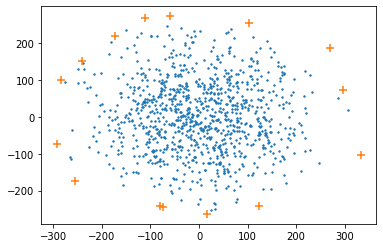

In [36]:
from itertools import combinations

def convex_hull1(points):
    filtered = [False] * len(points)
                    
    for i,j,k in combinations(range(len(points)),3):
        if any(filtered[idx] for idx in (i,j,k)):
            continue
            
        a=points[i]
        b=points[j]
        c=points[k]
        
        for idx, p in enumerate(points):
            if idx not in (i,j,k) and inside_tri(a,b,c,p):
                filtered[idx]=True
                
    return filtered

points = generate_points(1000)
run_convex_hull(points, convex_hull1)

### Exercise 4:
A few "simple" changes could dramatically reduce the practical performance of this algorithm. Examples include "pruning" techniques (ensuring that we avoid multiple unecessary checks). Implement such an algorithm, where:
* we avoid seeing permutations of the same triangle (abc), (acb), (cab), (cba), (bac), (bca)
* we avoid checking points that we know we do not need to check

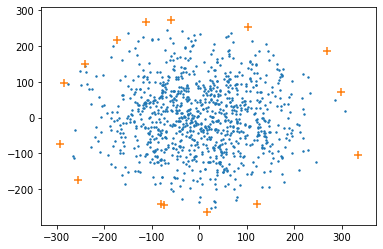

In [7]:
def convex_hull2(points):
    filtered = [False] * len(points)

    for p in range(len(points)):
        if filtered[p]:
            continue

        for q in range(len(points)):
            if filtered[q] or p == q:
                continue

            for r in range(len(points)):
                if filtered[r] or r in (p, q):
                    continue

                for s in range(len(points)):
                    if filtered[s] or s in (p, q, r):
                        continue

                    filtered[s] = inside_tri(points[p], points[q], points[r], points[s])

    return filtered

points = generate_points(1000)
run_convex_hull(points, convex_hull2)

In [10]:
points = generate_points(500)
%timeit convex_hull1(points)
%timeit convex_hull2(points)

8.28 s ± 2.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
168 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We know that points may cluster together, so choosing larger triangles could eliminate more internal points in one go. Can we intelligently choose triangles to select large ones and avoid small or narrow ones?